In [71]:
## load in relevant packages
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
import pandas as pd  
import numpy as np
import gpflow
import math as ma
from sklearn.preprocessing import StandardScaler  
feature_scaler = StandardScaler()

np.random.seed(5)

## setting to include the trained sensor points
#include_trained = False
## set max number
N = 50
## set number of sensor locations to find
k = 20
## set percent of N to train on
perc = .10

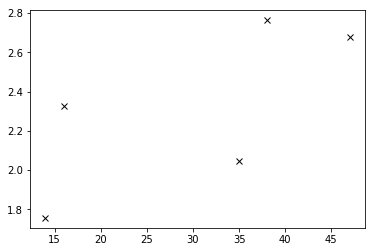

In [72]:
## subset to the trained data
sub = ma.ceil(perc*N)
## create fake data for model
noiseSize = 0.05
#x_train = np.linspace(-3,3,N)
#y_train = np.random.exponential(np.sin(x_train)**2) + np.random.randn(N,1)*noiseSize

X = np.random.randint(0,N,sub)
X = X.reshape(-1,1)
X = X.astype(float)
#Y = np.random.randn(sub)
#Y = Y.reshape(-1,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X)  + np.random.randn(sub,1)*noiseSize + 3
#print(X.shape)
#print(Y.shape)
#print(X)
#print(Y)

## plot distribution of selected sensors
plt.plot(X, Y, 'kx')

x_train = X
y_train = Y

In [73]:
## build model
kernel = gpflow.kernels.RBF(1, active_dims=[0], lengthscales=1.0)
## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

## view 
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [74]:
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.042411
  Number of iterations: 29
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 5.042411
  Number of iterations: 29
  Number of functions evaluations: 33


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                value  
GPR/kern/lengthscales           True   141.28076689512338  
GPR/kern/variance               True    5.433864860990479  
GPR/likelihood/variance         True  0.12086105652680339  


In [75]:
## define x-values not used for training
x_new = np.arange(0,N+1,1)
x_new = np.setdiff1d(x_new, x_train)
x_new = x_new.reshape(-1,1)
#print(x_new)

In [76]:
## example: thought exercise
## 5 sensor locations: S = [4,5,6,7,8]
## total number of sensors to find: k = 2
## for each iteration (1:k):
    ## for each possible sensor location (y) not in A (S):
        ## calculate: corr(y)^2 - corr(yA)*np.linalg.inv(corr(AA))*corr(Ay) / corr(y)^2 - corr(ynA)*np.linalg.inv(corr(nAA))*corr(nAy)
    ## select max(store_val)
    ## append y to A

## possible sensor locations
S = x_new
## number of sensors to find
k = k
## selected sensors
A = np.array([])
#if include_trained == True:
#    A = x_train
#else:
#    A = np.array([])

In [ ]:
## x is np.array or single value
def generate_cov_mat(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x).reshape(-1,1)
    ## select the 2nd object and bring up one dimension
    cov_mat = m.predict_f_full_cov(x)[1][0,:,:]
    return(cov_mat)

In [ ]:
def pick_best_sensors_krause(S, k, A, verbose=False):

    ## take out locations already in A before checks
    #S = S[np.isin(S, A, invert=True)]
    
    ## checks
    if k > S.shape[0]:
        print("error! k must be smaller than S")
        return
    if k/S.shape[0] > 0.25:
        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    ## add for 2-d, 3-d, etc
    
    ## create definition to generate model
    
    ## later version:
    ## use one full matrix and subset from
    
    ## additional checks:
    ## length of A + k should be less than S
    
    ## for each sensor to be added:
    for j in range(k):
        ## find coordinates not already in A to iterate through
        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
        delta = np.array([])
        ## print iteration
        print("Starting iteration: " + str(j))
    
        for y in Y:
            ## define how many sensor sites already exist
            len_A = A.shape[0]
            ## place current y in front of A
            yA = np.append(y,A)
            ## define possible sensor sites not including y & A
            nyA = S[np.isin(S, yA, invert=True)]
            ## define how many possible sites
            len_nA = nyA.shape[0]
            ## place current y in front of not y&A
            nyA = np.append(y,nyA)
            
            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
            cov_mat_A = generate_cov_mat(yA)
            ## select y's covariance
            y_cov = cov_mat_A[:1,[0]]
        
            ## grab covariance values
            ## make sure A is not empty
            #print("Determinant: " + str(np.linalg.det(cov_mat_A[1:len_A+1, 1:len_A+1])))
            
            if len_A > 0:
                AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
                yA_cov = cov_mat_A[[0],1:len_A+1]
                Ay_cov = yA_cov.T
                calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
            else:
                calc_1 = y_cov**2
            
            cov_mat_nA = generate_cov_mat(nyA)
            nAA_cov = np.linalg.inv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
            nAy_cov = nyA_cov.T
        
            calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
            value = calc_1 / calc_2
            delta = np.append(delta, value)
            
        y_star = np.array(Y[np.argmax(delta)])
        A = np.append(A, y_star)
        
        if verbose == True:
            #print(Y)
            #print(delta)
            print("Max value: " + str(np.amax(delta)))
            print("Picking sensor site: " + str(y_star))
    
    return(A)

In [ ]:
best_sensors = pick_best_sensors_krause(S=x_new, k=k, A=A, verbose=True)
best_sensors = best_sensors.reshape(-1,1)
print(best_sensors)
#added_sensors = best_sensors[np.isin(best_sensors, x_train, invert=True)]

In [ ]:
## plot distribution of sensors
#sns.stripplot
#sns.stripplot(x=x_train, jitter=0.03, color='blue', alpha=0.5)
#sns.stripplot(x=x_new, jitter=0.03, color='green', alpha=0.1)
#sns.stripplot(x=added_sensors, jitter=0.03, color='red', alpha=0.8)

In [ ]:
#N = 12
#X = np.random.rand(N,1)
#Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
#print(Y.shape)
#print(X.shape)
#plt.plot(X, Y, 'kx', mew=2)

#k = gpflow.kernels.Matern52(1, lengthscales=0.3)
#m = gpflow.models.GPR(X, Y, kern=k)
#m.likelihood.variance = 0.01
#m.compile()

In [ ]:
def plot(m):
    ## true underlying function: dashed line
    ## mean: green line
    ## shade: sd
    ## training points: x's
    ## selected sensor points: other shape
    xx = np.linspace(0, N, N+1)[:,None]
    ## actual function
    yy = np.sin(12*xx) + 0.66*np.cos(25*xx)  + np.random.randn(N+1,1)*noiseSize + 3
    ## predict values
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    
    mean_train, var_train = m.predict_y(x_train)
    plt.plot(x_train, mean_train, 'ko', mew=2)
    
    mean_sensors, var_sensors = m.predict_y(best_sensors)
    plt.plot(best_sensors, mean_sensors, 'rv', mew=2)
    
    plt.plot(xx, yy, 'k--', alpha=0.5)
    plt.plot(xx, mean, 'g', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='green', alpha=0.1)
    plt.xlim(0, N)
    plt.title('Selected Sensors, N=' + str(N))
    plt.savefig('../figures/selected_sensors_' + str(N))
plot(m)

In [81]:
## aggregated over time
dta = pd.read_csv("../data/kcl_london_model_data_winter_agg_time.csv", sep=',')
params = ['latitude', 'longitude']
X = dta[params].values
## rescale lat/long and year data
X = feature_scaler.fit_transform(X)
y = dta.loc[:,'nox'].values
y = y.reshape(-1,1)

In [82]:
print(X.shape)

(1981, 2)


In [83]:
## setting to include the trained sensor points
#include_trained = False
## set max number
N = 50
## set number of sensor locations to find
k = 5
## set percent of N to train on
perc = .10

In [84]:
## subset to the trained data
sub = ma.ceil(perc*N)
## create fake data for model
noiseSize = 0.05
print(sub)

5


In [85]:
## take sample for training
x_train = X[0:sub,:]
print(x_train.shape)
y_train = y[0:sub,:]
print(y_train.shape)

## standardize y-values
y_train = feature_scaler.fit_transform(y_train)

(5, 2)
(5, 1)


In [86]:
## build model
kernel = gpflow.kernels.RBF(2, active_dims=[0,1], lengthscales=1.0)

## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

## view 
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [87]:
## Run Model
## Marginal Liklihood Maximization
## picks the most simple model that picks the data the best
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.094693
  Number of iterations: 19
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.094693
  Number of iterations: 19
  Number of functions evaluations: 20


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                 value  
GPR/kern/lengthscales           True    0.0679467869989709  
GPR/kern/variance               True    0.9894247693472301  
GPR/likelihood/variance         True  0.010574390897254548  


In [92]:
## define x-values not used for training
x_new = X[sub+1:N+1,:]
print(x_new.shape)
#x_new = x_new.reshape(-1,1)
#print(x_new.shape)

(45, 2)


In [122]:
## possible sensor locations, assign index of locations
S = np.arange(0,x_new.shape[0]).reshape(x_new.shape[0],1)
## number of sensors to find
k = k
## selected sensors (indices)
A = np.array([])

In [123]:
## x is np.array or single value
def generate_cov_mat(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x).reshape(-1,1)
    cov_mat = m.predict_f_full_cov(x)[1][0,:,:]
    return(cov_mat)

In [125]:
print(S.shape)
print(S)

(45, 1)
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]
 [40]
 [41]
 [42]
 [43]
 [44]]


In [ ]:
## define how many sensor sites already exist
len_A = A.shape[0]
## place current y in front of A
yA = np.append(y,A)
## define possible sensor sites not including y & A
nyA = S[np.isin(S, yA, invert=True)]
## define how many possible sites
len_nA = nyA.shape[0]
## place current y in front of not y&A
nyA = np.append(y,nyA)

In [139]:
A = np.array([3,6])
print(A.shape)

Y = S[np.isin(S, A, invert=True)]
print(Y)

(2,)
[ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


In [138]:
print(x_new)

[[ 1.48798828  1.34477407]
 [ 0.82437672 -1.76280432]
 [ 0.16312761 -1.56452644]
 [-0.17799189 -1.17235838]
 [-1.37062053 -1.1195667 ]
 [-2.02159418 -1.05759909]
 [-2.0213646  -1.05604121]
 [ 0.09762246 -0.90463169]
 [-0.12725477 -0.83664993]
 [-0.32341918 -0.70989532]
 [-0.12312478 -0.62249236]
 [-2.14595822 -0.44405241]
 [-0.7016957  -0.41601461]
 [-0.07952891 -0.33743054]
 [-0.20799701 -0.27116497]
 [-0.02163191 -0.24532959]
 [ 0.23941884 -0.00787962]
 [ 1.67932657  0.01494142]
 [-0.89576444  0.02582487]
 [-2.19542134  0.04987496]
 [ 0.87396724  0.0613686 ]
 [-2.00951264  0.18637943]
 [ 2.41962587  0.26452075]
 [-1.20529908  0.32037006]
 [ 1.57345787  0.36638916]
 [-0.29544402  0.40139434]
 [ 1.82128316  0.4774572 ]
 [ 0.35085396  0.53225715]
 [ 0.59082036  0.78693162]
 [-0.27150255  0.79961178]
 [ 1.02282961  0.82596897]
 [-1.50124807  0.90992904]
 [-1.51211053  0.92070587]
 [ 1.21208729  0.99692283]
 [-0.70385201  1.34534684]
 [ 1.15421576  1.94022222]
 [ 0.32311215  2.10811913]
 

In [165]:
X = x_new
y = 0
A = np.array([3,6])

yA = np.append(np.array([y]), A, axis=0)
print(yA.shape)
yA_val = x_new[yA,:].reshape(yA.shape[0],x_new.shape[1])
print(yA_val.shape)

#y_val = X[y,:].reshape(1,x_new.shape[1])
#A_val = x_new[A,:]
#print(y_val)
#print(x_new)
#print(A)
#print(A_val.shape)
#print(y_val.shape)
#print(A_val)
#print(y_val)

#yA = np.append(y_val, A_val, axis=0)
#print(yA.shape)
print(yA_val)

(3,)
(3, 2)
[[ 1.48798828  1.34477407]
 [-0.17799189 -1.17235838]
 [-2.0213646  -1.05604121]]


In [174]:
nyA = S[np.isin(S, yA, invert=True)]
print(nyA.shape)
print(nyA)
nyA = np.append(np.array([y]), nyA, axis=0)
print(nyA.shape)
nyA_val = x_new[nyA,:].reshape(nyA.shape[0],x_new.shape[1])
print(nyA_val.shape)

(42,)
[ 1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
(43,)
(43, 2)


In [173]:
print(yA_val.shape)
cov_mat_A = generate_cov_mat(yA_val)
print(cov_mat_A.shape)

(3, 2)
(3, 3)


In [ ]:
def pick_best_sensors_krause(S, X, k, A, verbose=False):

    ## take out locations already in A before checks
    #S = S[np.isin(S, A, invert=True)]
    
    ## checks
    if k > S.shape[0]:
        print("error! k must be smaller than S")
        return
    if k/S.shape[0] > 0.25:
        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    ## add for 2-d, 3-d, etc
    
    ## create definition to generate model
    
    ## later version:
    ## use one full matrix and subset from
    
    ## additional checks:
    ## length of A + k should be less than S
    
    
    ## for each sensor to be added:
    for j in range(k):
        ## find coordinates not already in A to iterate through
        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
        delta = np.array([])
        ## print iteration
        print("Starting iteration: " + str(j))
    
        for y in Y:
            
            
            
            
            ## define how many sensor sites already exist
            len_A = A.shape[0]
            ## place current y in front of A
            yA = np.append(y,A)
            ## define possible sensor sites not including y & A
            nyA = S[np.isin(S, yA, invert=True)]
            ## define how many possible sites
            len_nA = nyA.shape[0]
            ## place current y in front of not y&A
            nyA = np.append(y,nyA)
            
            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
            cov_mat_A = generate_cov_mat(yA)
            ## select y's covariance
            y_cov = cov_mat_A[:1,[0]]
        
            ## grab covariance values
            ## make sure A is not empty
            #print("Determinant: " + str(np.linalg.det(cov_mat_A[1:len_A+1, 1:len_A+1])))
            
            if len_A > 0:
                AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
                yA_cov = cov_mat_A[[0],1:len_A+1]
                Ay_cov = yA_cov.T
                calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
            else:
                calc_1 = y_cov**2
            
            cov_mat_nA = generate_cov_mat(nyA)
            nAA_cov = np.linalg.inv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
            nAy_cov = nyA_cov.T
        
            calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
            value = calc_1 / calc_2
            delta = np.append(delta, value)
            
        y_star = np.array(Y[np.argmax(delta)])
        A = np.append(A, y_star)
        
        if verbose == True:
            #print(Y)
            #print(delta)
            print("Max value: " + str(np.amax(delta)))
            print("Picking sensor site: " + str(y_star))
    
    return(A)

In [6]:
X = np.random.randint(0,20,N)

a1 = np.arange(0,20,1)
a2 = np.arange(0,20,1)

com = np.vstack((a1, a2)).T
com.shape
print(com)

[[ 0  0]
 [ 1  1]
 [ 2  2]
 [ 3  3]
 [ 4  4]
 [ 5  5]
 [ 6  6]
 [ 7  7]
 [ 8  8]
 [ 9  9]
 [10 10]
 [11 11]
 [12 12]
 [13 13]
 [14 14]
 [15 15]
 [16 16]
 [17 17]
 [18 18]
 [19 19]]
